In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import pprint
import time
import datetime
import sys
import os
import torch
import numpy as np
import shutil
import os
import warnings
from tqdm import tqdm
import codecs
import webdataset as wds
import omegaconf

from sdofm.utils import days_hours_mins_secs_str
from sdofm.datasets import TimestampedSDOMLDataModule, SDOMLDataModule
from sdofm.pretraining import NVAE, MAE

In [4]:
cfg = omegaconf.OmegaConf.load("../experiments/pretrain_32.2M_samae_tpu_128.yaml")

data_module = TimestampedSDOMLDataModule(
    # hmi_path=os.path.join(
    #     cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=[],  # cfg.data.month_splits.val,
    # test_months=[1,2,3,4,5,6,7,8,9,10,11,12], #cfg.data.month_splits.test,
    holdout_months=[],  # =cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.cache
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
    num_frames=cfg.data.num_frames,
    drop_frame_dim=False,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.


[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [5]:
# model = NVAE.load_from_checkpoint('/home/walsh/SDO-FM/outputs/2024-07-02/13-46-18/sdofm/ds441v0c/checkpoints/epoch=5-step=86538.ckpt', map_location=torch.device('cpu'))
model = MAE.load_from_checkpoint(
    "/home/walsh/SDO-FM/artifacts/model-q1l4qkjj:v4/model.ckpt",
    map_location=torch.device("cpu"),
)

In [6]:
dl = data_module.test_dataloader()
batch = next(iter(dl))

In [7]:
len(dl)

89039

In [8]:
batch["image_stack"].shape

torch.Size([1, 9, 1, 512, 512])

In [31]:
list(batch["timestamps"][0])

['2011-11-01 00:00:00', '2011-11-01 00:12:00']

In [32]:
from sdofm.models import ConvTransformerTokensToEmbeddingNeck

latent_dim = cfg.model.mae.embed_dim

num_tokens = 512 // 16

In [40]:
num_tokens

32

In [37]:
emb_decoder = ConvTransformerTokensToEmbeddingNeck(
    embed_dim=latent_dim,
    # output_embed_dim=32,
    output_embed_dim=32,
    Hp=num_tokens,
    Wp=num_tokens,
    drop_cls_token=True,
    num_frames=1,
)

In [43]:
emb_decoder.Hp

32

In [10]:
data = batch
x, timestamps = data["image_stack"], data["timestamps"][0]

In [31]:
x = model.autoencoder.patch_embed(x)

In [32]:
x.shape

torch.Size([1, 1024, 2048])

In [33]:
9 * 512 * 512

2359296

In [34]:
1025 * 2048

2099200

In [43]:
f"{(21000/(9*512*512))*100:1f}%"

'0.890096%'

In [51]:
f"{((1025*128)/(9*512*512)*100)*0.54*0.25:2f}%"

'0.750732%'

In [ ]:
1025 * 128

In [17]:
x_hat, mask, ids_restore = model.autoencoder.forward_encoder(x, mask_ratio=0.0)
# x_hat = x_hat.squeeze(dim=2)
# z = emb_decoder(x_hat)

In [29]:
x_hat.shape

torch.Size([1, 1025, 2048])

In [25]:
model.autoencoder.decoder_embed(x_hat).shape

torch.Size([1, 1025, 512])

In [19]:
mask.shape

torch.Size([1, 1024])

In [22]:
(512 // 16) ** 2  # num of patches

1024

In [16]:
model.autoencoder.decoder_embed

Linear(in_features=2048, out_features=512, bias=True)

In [28]:
model.autoencoder.forward_decoder(x_hat, ids_restore).shape

torch.Size([1, 1024, 2304])

In [53]:
1024 * 2048

2097152

In [56]:
32 * 512 * 512

8388608

In [36]:
z.shape

torch.Size([2, 2048, 512, 512])

In [39]:
z.shape

torch.Size([2, 32, 512, 512])

In [44]:
import matplotlib.pyplot as plt

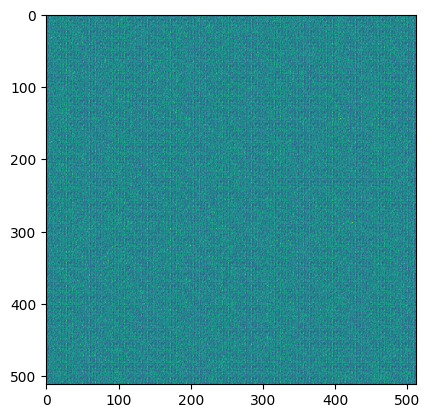

In [51]:
d = z.detach().numpy()
plt.imshow(d[0, 23, :, :])

In [10]:
z = model.encode(torch.tensor(batch["image_stack"]))

AttributeError: 'MAE' object has no attribute 'encode'

In [20]:
z.detach().cpu().numpy()[0]

array([-0.08459403, -0.79256976,  1.5746768 , ..., -2.729113  ,
       -4.427163  , -3.9137645 ], dtype=float32)

In [22]:
datetime.datetime.now().strftime("%Y_%m_%d_%H%M")

'2024_07_03_23:31'

In [14]:
model.z_dim.shape[0]

21504

In [19]:
model.z_shapes

tensor([[  1.,  32.,  32.],
        [  1.,  64.,  64.],
        [  1., 128., 128.]])

In [23]:
import wandb

run = wandb.init(project="sdofm", id="q1l4qkjj")
artifact = run.use_artifact("fdlx/sdofm/model-q1l4qkjj:v4")
artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dead-water (fdlx). Use `wandb login --relogin` to force relogin


In [26]:
artifact = run.use_artifact("fdlx/sdofm/model-q1l4qkjj:v4")
artifact.download()
path = artifact.get_path("fdlx/sdofm/model-q1l4qkjj:v4")

wandb: Downloading large artifact model-q1l4qkjj:v4, 7294.21MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:57.7


TypeError: Artifact.get_path() missing 1 required positional argument: 'name'

In [37]:
artifact.get_path(name="model.ckpt")

ArtifactManifestEntry(path='model.ckpt', digest='83PI6BY4kSwFK3nyIxP+Hg==', birth_artifact_id='QXJ0aWZhY3Q6OTM2ODQwOTQy', size=7648532105, skip_cache=False)

In [43]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

21410496

NVAE = 21410496 = 21.4M trainable

In [45]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

636477696

MAE = 636477696 = 636M trainable

In [46]:
636 / 21.4

29.719626168224302

In [47]:
21000 / 2048

10.25390625